# Packages

In [2]:
using PyCall, CSV, DataFrames, Plots
#using StatsBase, MarketTechnicals, PrettyTables
using LinearAlgebra
using TimeSeries
using Dates
using Pandas
using MarketData
using Downloads

# Jl files

In [3]:
include("labeling.jl")

dropLabel

# Data

In [4]:
stocks = [:AAPL, :MSFT, :GOOG, :AMZN]
start = DateTime(2020, 1, 1)
All_Stocks = []
for symb in stocks
    data = DataFrames.DataFrame(yahoo(symb, YahooOpt(period1 = start)))
    adj_close_price = data.AdjClose
    if getindex(stocks, 1) == symb
        time_stamp = data.timestamp
        All_Stocks = hcat(time_stamp, adj_close_price)
    else
        All_Stocks = hcat(All_Stocks, adj_close_price)
    end
end
All_Stocks_Prices = DataFrames.DataFrame(All_Stocks, :auto)
All_Stocks_Prices = DataFrames.rename(All_Stocks_Prices, names(All_Stocks_Prices).=>String.(append!([:Dates], stocks)))
CSV.write("Data_Prices.csv", All_Stocks_Prices)

"Data_Prices.csv"

In [5]:
function pct_change(prices::DataFrames.DataFrame)
    returns = DataFrames.DataFrame()
    for sym in names(prices)[2:end]
        x = prices[!,Symbol(sym)]
        ret = Array{Float64}(undef,length(x))
        ret[1] = NaN
        for i in 2:length(x)
            ret[i] = (x[i]/x[i-1])-1
        end
        returns[!,Symbol(sym)] = ret
    end
    return returns
end

pct_change (generic function with 1 method)

In [6]:
All_Stocks_Returns = pct_change(All_Stocks_Prices)[1:end,:]
CSV.write("Data_Returns.csv", All_Stocks_Returns)
All_Stocks_Returns[1:10,:]

,AAPL,MSFT,GOOG,AMZN
,Float64,Float64,Float64,Float64
1,NaN,NaN,NaN,NaN
2,-0.00972194,-0.0124518,-0.00490727,-0.012139
3,0.00796825,0.00258461,0.0246572,0.0148856
4,-0.00470302,-0.00911747,-0.000624052,0.00209162
5,0.0160862,0.0159284,0.00788039,-0.00780864
6,0.021241,0.0124928,0.0110445,0.00479918
7,0.0022605,-0.00462702,0.00697271,-0.0094106
8,0.0213644,0.0120243,0.00664458,0.00432257
9,-0.0135032,-0.00704318,-0.00580175,-0.0115582


In [7]:
close = All_Stocks_Prices[!, [:Dates, :AAPL]]
close[1:10, :]

,Dates,AAPL
,Any,Any
1,2020-01-02,73.6836
2,2020-01-03,72.9672
3,2020-01-06,73.5486
4,2020-01-07,73.2027
5,2020-01-08,74.3803
6,2020-01-09,75.9602
7,2020-01-10,76.1319
8,2020-01-13,77.7584
9,2020-01-14,76.7084


# Snippet 3-1

In [8]:
rets, stds = dailyVol(close, 32);

In [9]:
first(rets, 10)

,x1,x2
,Any,Any
1,2020-01-06,0.00796825
2,2020-01-07,0.00322775
3,2020-01-08,0.0113075
4,2020-01-09,0.0376688
5,2020-01-10,0.0235495
6,2020-01-13,0.0213644
7,2020-01-14,0.00757267
8,2020-01-15,-0.0177309
9,2020-01-16,0.00818722


In [10]:
first(stds, 10)

,x1,x2
,Any,Any
1,2020-01-06,NaN
2,2020-01-07,0.00335204
3,2020-01-08,0.00411546
4,2020-01-09,0.0158589
5,2020-01-10,0.0139895
6,2020-01-13,0.0124193
7,2020-01-14,0.0119763
8,2020-01-15,0.0171325
9,2020-01-16,0.0157975


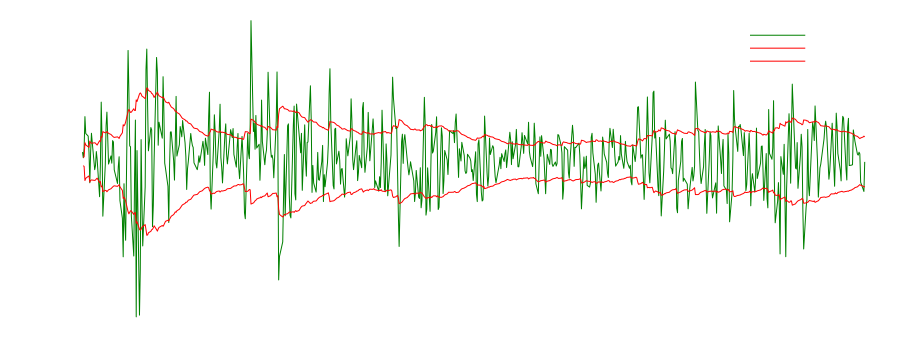

In [14]:
pt = Plots.plot(rets[!, 1], rets[!, 2], label = "rets", 
        linecolor = :green, size = (900, 350), background = :transparent)
pt = Plots.plot!(rets[!, 1], stds[!, 2], label = "stds", 
        linecolor = :red, size = (900, 350), background = :transparent)
pt = Plots.plot!(rets[!, 1], -stds[!, 2], label = "-stds", 
        linecolor = :red, size = (900, 350), background = :transparent)

In [16]:
savefig(pt, "Figs/returns.png")

# Snippet 3-2

In [17]:
timeEvents = events(close, 5)
first(timeEvents, 10)

10-element Vector{Any}:
 2020-01-17
 2020-02-24
 2020-02-27
 2020-03-02
 2020-03-09
 2020-03-12
 2020-03-13
 2020-03-16
 2020-03-20
 2020-03-24

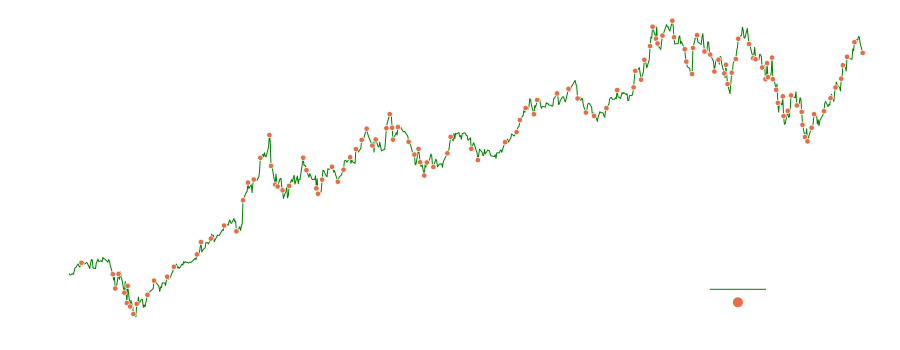

In [21]:
closeFiltered = filter(row->row[:Dates] in timeEvents, close)
pt = Plots.plot(close[!, 1], close[!, 2], label = "close", 
        linecolor = :green, size = (900, 350), background = :transparent, legend =:bottomright)
pt = Plots.scatter!(timeEvents, closeFiltered[!, 2], markersize = 3, label = "timeEvents", 
        linecolor = :red, size = (900, 350), background = :transparent, legend =:bottomright)


In [22]:
savefig(pt, "Figs/TimeEvents.png")

In [23]:
timestamp = repeat([NaN], length(timeEvents))
side = repeat([1.], length(timeEvents))
target = filter(row -> row[:x1] in timeEvents, stds)
ptsl = [1, 1]
events1 = DataFrames.DataFrame(hcat(timeEvents, timestamp, target[:, :x2], side), :auto)
DataFrames.rename!(events1, names(events1) .=> ["date", "timestamp", "target", "side"]) 
first(events1, 15)

,date,timestamp,target,side
,Any,Any,Any,Any
1,2020-01-17,NaN,0.0153509,1.0
2,2020-02-24,NaN,0.0241388,1.0
3,2020-02-27,NaN,0.0309963,1.0
4,2020-03-02,NaN,0.0419594,1.0
5,2020-03-09,NaN,0.0442898,1.0
6,2020-03-12,NaN,0.0517208,1.0
7,2020-03-13,NaN,0.0503633,1.0
8,2020-03-16,NaN,0.0566531,1.0
9,2020-03-20,NaN,0.0545028,1.0


In [24]:
out = tripleBarrier(close, events1, ptsl, timeEvents)
first(out, 20)

,date,timestamp,stoploss,profitTaking
,Any,Any,Union…,Union…
1,2020-01-17,NaN,2020-01-27,2020-01-29
2,2020-02-24,NaN,2020-02-25,2020-05-08
3,2020-02-27,NaN,2020-03-12,2020-03-02
4,2020-03-02,NaN,2020-03-09,2020-05-11
5,2020-03-09,NaN,2020-03-12,2020-03-10
6,2020-03-12,NaN,2020-03-20,2020-03-13
7,2020-03-13,NaN,2020-03-16,2020-04-30
8,2020-03-16,NaN,2020-03-23,2020-03-26
9,2020-03-20,NaN,NaN,2020-03-24


In [25]:
pt, sl = ptsl[1].*target[:,2], ptsl[2].*target[:,2]
closeFiltered = filter(row->row[:Dates] in timeEvents, close)
upperBound, lowerBound = closeFiltered[:,2].*(1 .+ pt), closeFiltered[:,2].*(1 .- sl);

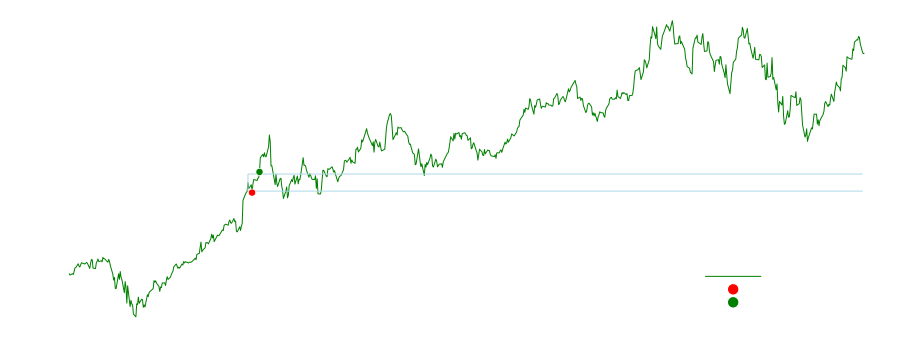

In [31]:
i = 21
begining, ending = out[i, :date], out[end, :date]
upper, lower = upperBound[i], lowerBound[i]
timesl, timept = out.stoploss[i], out.profitTaking[i]
pricesl, pricept = close[close.Dates .== timesl, 2][1], close[close.Dates .== timept, 2][1]
pt = Plots.plot(close[!, 1], close[!, 2], label = "close", 
        linecolor = :green, size = (900, 350), background = :transparent, legend =:bottomright)
pt = Plots.plot!([begining, begining], [lower,upper], label = nothing, linecolor = :lightblue, size = (900, 350))
pt = Plots.plot!([begining, ending], [lower,lower], label = nothing, linecolor = :lightblue, size = (900, 350))
pt = Plots.plot!([begining, ending], [upper,upper], label = nothing, linecolor = :lightblue, size = (900, 350))
pt = Plots.scatter!([timesl], [pricesl], label = "stop-loss", color = :red, size = (900, 350))
pt = Plots.scatter!([timept], [pricept], label = "profit-taking", color = :green, size = (900, 350))

In [32]:
savefig(pt, "Figs/ProfitLoss.png")

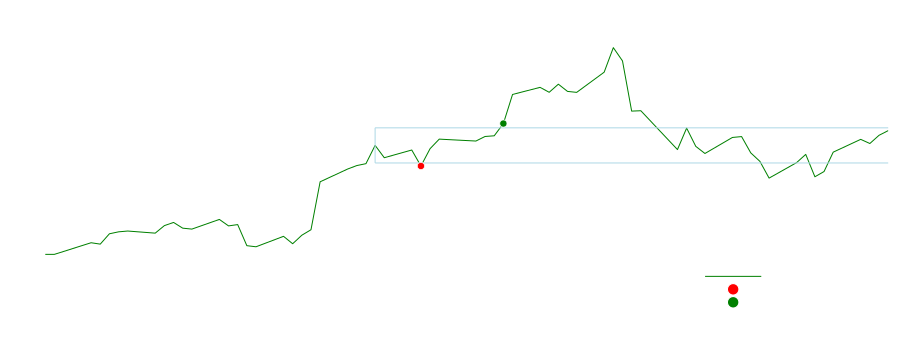

In [37]:
i = 21
begining, ending = out[i, :date], out[end, :date]
upper, lower = upperBound[i], lowerBound[i]
timesl, timept = out.stoploss[i], out.profitTaking[i]
pricesl, pricept = close[close.Dates .== timesl, 2][1], close[close.Dates .== timept, 2][1]
pt = Plots.plot(close[!, 1], close[!, 2], label = "close", linecolor = :green, 
        size = (900, 350), background = :transparent, legend = :bottomright)
pt = Plots.plot!([begining, begining], [lower,upper], label = nothing, linecolor = :lightblue, size = (900, 350))
pt = Plots.plot!([begining, ending], [lower,lower], label = nothing, linecolor = :lightblue, size = (900, 350))
pt = Plots.plot!([begining, ending], [upper,upper], label = nothing, linecolor = :lightblue, size = (900, 350))
pt = Plots.scatter!([timesl], [pricesl], label = "stop-loss", color = :red, size = (900, 350))
pt = Plots.scatter!([timept], [pricept], label = "profit-taking", color = :green, size = (900, 350))
xlims!((Date(2020,07,01),Date(2020,10,01)))
ylims!((75, 140))

In [38]:
savefig(pt, "Figs/ProfitLoss2.png")

# Snippet 3.3 & 3.4

In [40]:
events2 = events(close, timeEvents, 1., stds, 0.04, timestamp = timestamp)

,date,timestamp,target
,Any,Date,Any
1,2020-03-02,2020-03-09,0.0419594
2,2020-03-09,2020-03-10,0.0442898
3,2020-03-12,2020-03-13,0.0517208
4,2020-03-13,2020-03-16,0.0503633
5,2020-03-16,2020-03-23,0.0566531
6,2020-03-20,2020-03-24,0.0545028
7,2020-03-24,2020-04-06,0.0569224
8,2020-04-06,2020-04-14,0.056973
9,2020-04-14,2020-04-21,0.0542066


In [41]:
t1 = verticalBarrier(close, timeEvents, 21)
first(t1, 15)

,x1,x2
,Date,Date
1,2020-01-17,2020-02-07
2,2020-02-24,2020-03-16
3,2020-02-27,2020-03-19
4,2020-03-02,2020-03-23
5,2020-03-09,2020-03-30
6,2020-03-12,2020-04-02
7,2020-03-13,2020-04-03
8,2020-03-16,2020-04-06
9,2020-03-20,2020-04-13


In [42]:
events2 = events(close, timeEvents, 1., stds, 0.04, timestamp = t1[:, 2])

,date,timestamp,target
,Any,Date,Any
1,2020-03-02,2020-03-09,0.0419594
2,2020-03-09,2020-03-10,0.0442898
3,2020-03-12,2020-03-13,0.0517208
4,2020-03-13,2020-03-16,0.0503633
5,2020-03-16,2020-03-23,0.0566531
6,2020-03-20,2020-03-24,0.0545028
7,2020-03-24,2020-04-06,0.0569224
8,2020-04-06,2020-04-14,0.056973
9,2020-04-14,2020-04-21,0.0542066


In [43]:
pt, sl = events2.target, events2.target
closeFiltered = filter(row->row[:Dates] in events2.date, close)
upperBound, lowerBound = closeFiltered[:,2].*(1 .+ pt), closeFiltered[:,2].*(1 .- sl);

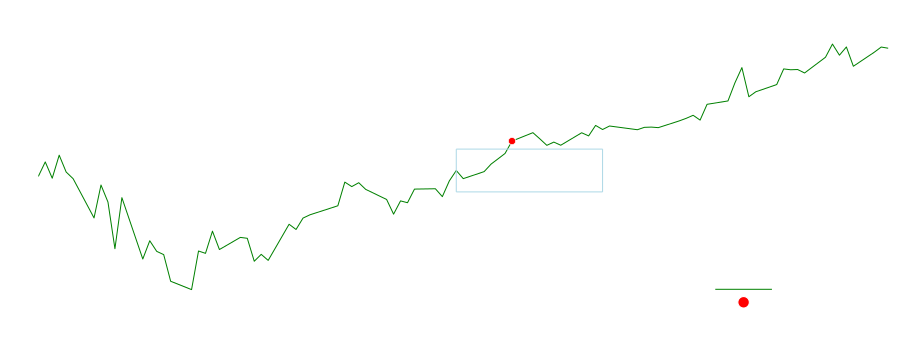

In [46]:
i = 10
begining, ending = events2[i, :date], filter(row->row[:x1] in events2.date, t1)[i,2]
firstTouch = events2[i, :timestamp]
priceTouch = close[close.Dates .== firstTouch, 2][1]
upper, lower = upperBound[i], lowerBound[i]

pt = Plots.plot(close[!, 1], close[!, 2], label = "close", linecolor = :green, 
        size = (900, 350), background = :transparent, legend = :bottomright)
pt = Plots.plot!([begining, begining], [lower,upper], label = nothing, linecolor = :lightblue, size = (900, 350))
pt = Plots.plot!([begining, ending], [lower,lower], label = nothing, linecolor = :lightblue, size = (900, 350))
pt = Plots.plot!([begining, ending], [upper,upper], label = nothing, linecolor = :lightblue, size = (900, 350))
pt = Plots.plot!([ending,ending], [lower,upper], label = nothing, linecolor = :lightblue, size = (900, 350))
pt = Plots.scatter!([firstTouch], [priceTouch], label = "first-touch", color = :red, size = (900, 350))
xlims!((Date(2020,03,01), Date(2020,07,01)))
ylims!((50, 95))

In [47]:
savefig(pt, "Figs/FirstTouch.png")

# Snippet 3.5

In [48]:
label(events2, close)

,Dates,ret,bin
,Any,Float64,Float64
1,2020-03-02,-0.109233,-1.0
2,2020-03-09,0.0720216,1.0
3,2020-03-12,0.119808,1.0
4,2020-03-13,-0.128647,-1.0
5,2020-03-16,-0.0736553,-1.0
6,2020-03-20,0.07695,1.0
7,2020-03-24,0.063148,1.0
8,2020-04-06,0.0936487,1.0
9,2020-04-14,-0.0650759,-1.0


# Snippet 3.6

In [49]:
events3 = eventsMeta(close, timeEvents, [1,1], stds, 0.04, timestamp = t1[:, 2])

,date,timestamp,target
,Any,Date,Any
1,2020-03-02,2020-03-09,0.0419594
2,2020-03-09,2020-03-10,0.0442898
3,2020-03-12,2020-03-13,0.0517208
4,2020-03-13,2020-03-16,0.0503633
5,2020-03-16,2020-03-23,0.0566531
6,2020-03-20,2020-03-24,0.0545028
7,2020-03-24,2020-04-06,0.0569224
8,2020-04-06,2020-04-14,0.056973
9,2020-04-14,2020-04-21,0.0542066


# Snippet 3.7

In [50]:
out4 = labelMeta(events3, close)

,Dates,ret,bin
,Any,Float64,Float64
1,2020-03-02,-0.109233,-1.0
2,2020-03-09,0.0720216,1.0
3,2020-03-12,0.119808,1.0
4,2020-03-13,-0.128647,-1.0
5,2020-03-16,-0.0736553,-1.0
6,2020-03-20,0.07695,1.0
7,2020-03-24,0.063148,1.0
8,2020-04-06,0.0936487,1.0
9,2020-04-14,-0.0650759,-1.0


# Snippet 3.8

In [51]:
events4 = dropLabel(out4, percentMin = 0.05)

,Dates,ret,bin
,Any,Float64,Float64
1,2020-03-02,-0.109233,-1.0
2,2020-03-09,0.0720216,1.0
3,2020-03-12,0.119808,1.0
4,2020-03-13,-0.128647,-1.0
5,2020-03-16,-0.0736553,-1.0
6,2020-03-20,0.07695,1.0
7,2020-03-24,0.063148,1.0
8,2020-04-06,0.0936487,1.0
9,2020-04-14,-0.0650759,-1.0
